In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model  import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
JPM = yf.Ticker('JPM')
JPM = JPM.history(start='2014-12-29',end='2021-12-31')
JPM['Rendimenti'] = JPM['Open'].diff() # aggiungo i valori dei rendimenti
JPM.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Rendimenti
count,1765.000000,1765.000000,1765.000000,1765.000000,1.765000e+03,1765.000000,1765.0,1764.000000
mean,92.150689,93.008318,91.302414,92.150635,1.513972e+07,0.010561,0.0,0.060192
std,32.584003,32.882706,32.299042,32.572711,6.646317e+06,0.087102,0.0,1.613196
min,44.681977,45.383567,41.570073,44.559063,3.324300e+06,0.000000,0.0,-10.086370
25%,57.656299,57.925786,57.417006,57.690487,1.088610e+07,0.000000,0.0,-0.622669
50%,93.184591,94.177589,92.318723,93.221794,1.354240e+07,0.000000,0.0,0.070248
75%,104.620874,105.376342,103.911253,104.580658,1.725090e+07,0.000000,0.0,0.763075
max,170.417716,170.664397,168.276505,169.500061,5.619230e+07,1.000000,0.0,10.493416


ANALISI ESPLORATIVA

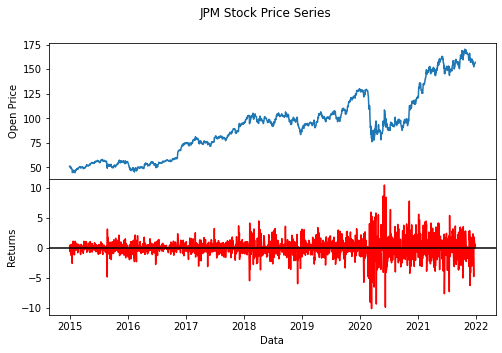

In [3]:
fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle('JPM Stock Price Series')
axs[0].plot(JPM['Open'])
axs[1].plot(JPM['Rendimenti'], color ="red")
axs[1].axhline(y=0.045864, color = "black", linestyle="solid")
axs[1].set_xlabel("Data")
axs[1].set_ylabel("Returns")
axs[0].set_ylabel("Open Price")
for ax in axs.flat:
    ax.label_outer()

# la serie mostra un forte trend, e una volatilità crescente con un cluster abbastanza corposo nell'ultimo periodo.
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\serie.pdf", bbox_inches='tight', format="pdf")

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


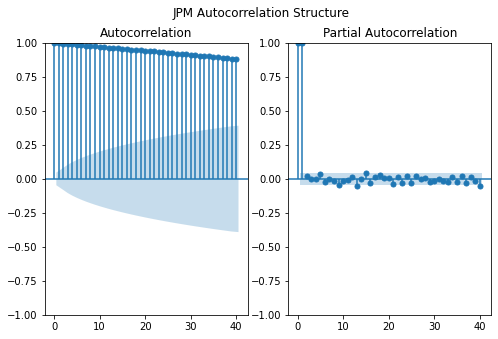

In [4]:
# ACF E PACF della serie; utile anche a capire l'ordine del modello ARIMA
fig, ax = plt.subplots(1, 2, figsize=(8,5))
plot_acf(JPM['Open'], lags=40, ax=ax[0])
plot_pacf(JPM['Open'], lags=40, ax=ax[1])
plt.suptitle("JPM Autocorrelation Structure")
plt.show()

In [5]:
#Test ADF per la verifica dell'ipotesi nulla di radice unitaria
adfTest = adfuller(JPM['Open'], autolag = 'AIC')
dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
print('Augmented Dickey-Fuller Test Results:\n')
print(dfResults)
# non si rifiuta l'ipotesi nulla di radice unitaria

Augmented Dickey-Fuller Test Results:

ADF Test Statistic       -0.431580
P-Value                   0.904691
# Lags Used               5.000000
# Observations Used    1759.000000
dtype: float64


MODELLAZIONE ARIMA



In [3]:
# creazione del train e del test set
size = int(len(JPM) * 0.72)
print(size)
dataset_train = JPM[0:size]
training_set = dataset_train.iloc[:, 0:1].values
dataset_test = JPM[size:]
test_set = dataset_test.iloc[:,0:1].values
print(training_set.shape)
print(test_set.shape)

1270
(1270, 1)
(495, 1)


In [4]:
history = [x for x in training_set]
predictions = list()
# walk-forward validation
for t in range(len(test_set)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_set[t]
    history.append(obs)

In [5]:
print(model_fit.summary()) # si rifiuta l'ipotesi nulla di normalità dei residui; il Ljung box è non significativo e quindi il modello filtra la serie
# dalla dipendenza seriale

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1764
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3344.409
Date:                Wed, 29 Jun 2022   AIC                           6692.818
Time:                        17:32:20   BIC                           6703.768
Sample:                             0   HQIC                          6696.865
                               - 1764                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0411      0.014     -2.948      0.003      -0.068      -0.014
sigma2         2.6016      0.042     62.621      0.000       2.520       2.683
Ljung-Box (L1) (Q):                   0.00   Jarque-

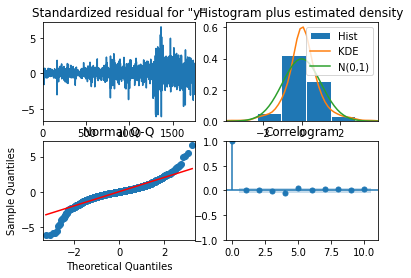

In [11]:
model_fit.plot_diagnostics() # forte asimmetria nella distribuzione dei residui
plt.show()

In [ ]:
print(test_set.shape)
print(np.array(predictions).shape)

(290, 1)
(290, 1)


In [6]:
# valutazione delle previsioni
mse = mean_squared_error(test_set, predictions)
print('Mean Squared Error:\t',mse)

Mean Squared Error:	 6.550982461634734


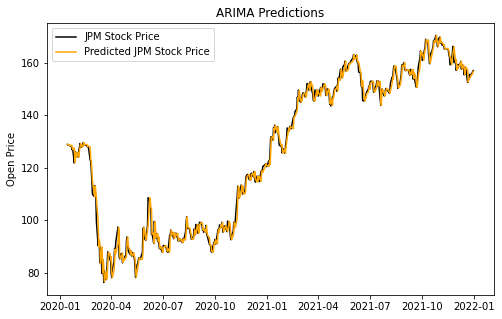

In [7]:
predictions = pd.DataFrame(predictions)
predictions= predictions.set_index(dataset_test.index)
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], color ="black", label = "JPM Stock Price")
plt.plot(predictions, color="orange", label = "Predicted JPM Stock Price")
plt.legend()
plt.ylabel("Open Price")
plt.title("ARIMA Predictions")
plt.show()
fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_arima.pdf", bbox_inches='tight', format="pdf")

CONVOLUTIONAL NEURAL NETWORK

In [8]:
mc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = mc.fit_transform(training_set)
print(training_set_scaled.shape)

(1270, 1)


In [9]:
# Costruzione del set di training per la multi-step walk forward validation con finestra temporale di 5 giorni
X_train = []
y_train = []
temp = 5
for i in range(temp, training_set.shape[0], temp):
  X_train.append(training_set_scaled[i-temp:i])
  y_train.append(training_set_scaled[i:i+temp])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(253, 5, 1)
(253, 5, 1)
(253, 5, 1)


In [10]:
# Costruzione del test set
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - temp:].values
inputs = inputs.reshape(-1,1)
inputs = mc.transform(inputs)
X_test = []
for i in range(5, inputs.shape[0], 5):
  X_test.append(inputs[i-temp:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(99, 5, 1)


In [37]:
model_5_CNN = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu', kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu",  kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.Dense(5, activation = "relu",  kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02))
    ]
)
model_5_CNN.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 3, 64)             256       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 5)                 165       
                                                                 
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
____________________________________________________

In [16]:
batch_size = 4
epochs = 20
optimizer = keras.optimizers.Adam()
model_5_CNN.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer, metrics=[keras.metrics.RootMeanSquaredError()])
model1_fitmodel_5_CNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
64/64 [==============================] - 1s 2ms/step - loss: 0.0830 - root_mean_squared_error: 0.2881
Epoch 2/20
64/64 [==============================] - 0s 3ms/step - loss: 0.0055 - root_mean_squared_error: 0.0741
Epoch 3/20
64/64 [==============================] - 0s 2ms/step - loss: 9.4173e-04 - root_mean_squared_error: 0.0307
Epoch 4/20
64/64 [==============================] - 0s 2ms/step - loss: 7.7864e-04 - root_mean_squared_error: 0.0279
Epoch 5/20
64/64 [==============================] - 0s 2ms/step - loss: 7.9042e-04 - root_mean_squared_error: 0.0281
Epoch 6/20
64/64 [==============================] - 0s 2ms/step - loss: 8.5439e-04 - root_mean_squared_error: 0.0292
Epoch 7/20
64/64 [==============================] - 0s 3ms/step - loss: 8.1477e-04 - root_mean_squared_error: 0.0285
Epoch 8/20
64/64 [==============================] - 0s 2ms/step - loss: 7.9742e-04 - root_mean_squared_error: 0.0282
Epoch 9/20
64/64 [==============================] - 0s 2ms/step - loss: 

In [18]:
predicted_stock_price = model_5_CNN.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price= predicted_stock_price.set_index(dataset_test.index)

Mean Squared Error:	 27.219139108452058
Root Mean Squared Error:	 5.217196479763059


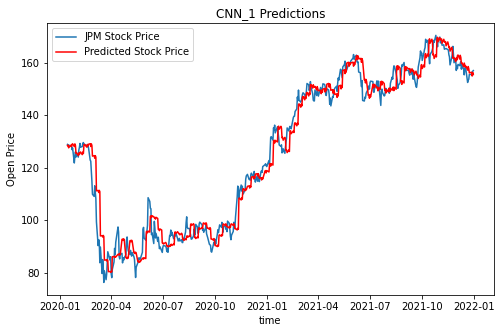

In [19]:
# MSE e rappresentazione delle previsioni
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("CNN_1 Predictions")
plt.legend()
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_cnn1.pdf", bbox_inches='tight', format="pdf")

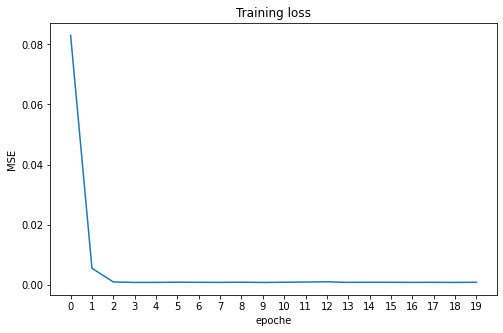

In [25]:
fig = plt.figure(figsize=(8,5))
plt.plot(model1_fit.history['loss'])
plt.xticks(range(0,20))
plt.xlabel("epoche")
plt.ylabel("MSE")
plt.title("Training loss")
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\loss_cnn1.pdf", bbox_inches='tight', format="pdf")

In [31]:
# cambio algoritmo di ottimizzazione: suo RMSprop
model_5_CNN_rms = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu', kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu",  kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.Dense(5, activation = "relu",  kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02))
    ]
)
model_5_CNN.summary()

batch_size = 4
epochs = 20
optimizer = keras.optimizers.RMSprop()
model_5_CNN_rms.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer, metrics=[keras.metrics.RootMeanSquaredError()])
model2_fit =model_5_CNN_rms.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 3, 64)             256       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
____________________________________________________

Mean Squared Error:	 35.8957742590075
Root Mean Squared Error:	 5.991308226006028


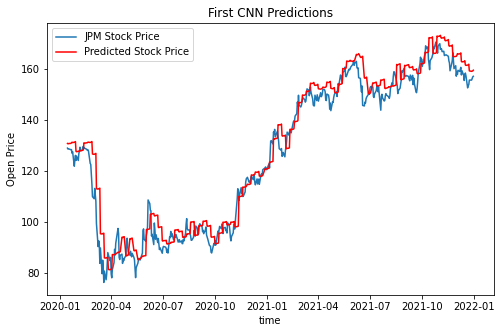

In [33]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_rms.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_cnn1_rms.pdf", bbox_inches='tight', format="pdf")

In [ ]:
fig = plt.figure(figsize=(8,5))
plt.plot(model2_fit.history['loss'])
plt.xticks(range(0,20))
plt.xlabel("epoche")
plt.ylabel("MSE")
plt.title("Training loss")
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\loss_cnn1_rms.pdf", bbox_inches='tight', format="pdf")

In [63]:
# provo ad utilizzare l'early stopping per cercare di evitare un possibile overfitting sul training
model_5_CNN_early = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu', kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu",  kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.Dense(5, activation = "relu",  kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02))
    ]
)
batch_size = 4
epochs = 20
earlyStop = keras.callbacks.EarlyStopping(patience=2, mode='min')
model_5_CNN_early.compile(loss=keras.losses.mean_squared_error, optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])
model3_fit =model_5_CNN_early.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[earlyStop])

Epoch 1/20
57/57 [==============================] - 1s 4ms/step - loss: 0.0681 - root_mean_squared_error: 0.2610 - val_loss: 0.0478 - val_root_mean_squared_error: 0.2185
Epoch 2/20
57/57 [==============================] - 0s 3ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0846
Epoch 3/20
57/57 [==============================] - 0s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 4/20
57/57 [==============================] - 0s 2ms/step - loss: 6.8919e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
Epoch 5/20
57/57 [==============================] - 0s 2ms/step - loss: 7.2767e-04 - root_mean_squared_error: 0.0270 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 6/20
57/57 [==============================] - 0s 2ms/step - loss: 7.4106e-04 - root_mean_squared_error: 0.0272 - val_loss: 0.0017 - val_

Mean Squared Error:	 27.78912851637585
Root Mean Squared Error:	 5.271539482577727


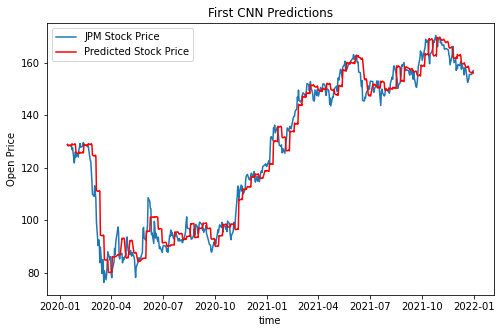

In [66]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_early.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_cnn1_early.pdf", bbox_inches='tight', format="pdf")

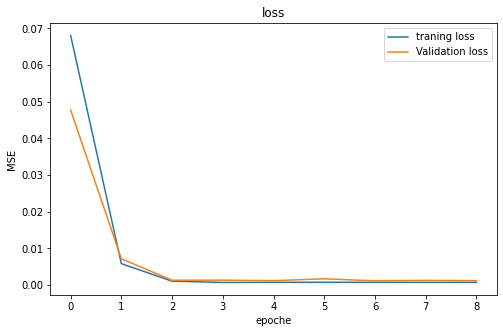

In [65]:
epoche = model3_fit.history['val_loss']
fig = plt.figure(figsize=(8,5))
plt.plot(model3_fit.history['loss'], label="traning loss")
plt.plot(model3_fit.history['val_loss'], label = "Validation loss")
plt.xticks(range(0,len(epoche)))
plt.xlabel("epoche")
plt.ylabel("MSE")
plt.title("loss")
plt.legend()
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\loss_cnn1_early.pdf", bbox_inches='tight', format="pdf")

In [69]:
# Modifico il learing rate a 0.02
model_5_CNN_3 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu', kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu", kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.Dense(5, activation = "relu", kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02))
    ]
)

optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model_5_CNN_3.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer, metrics=[keras.metrics.RootMeanSquaredError()])
model_4_fit = model_5_CNN_3.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[earlyStop])

Epoch 1/20
57/57 [==============================] - 1s 4ms/step - loss: 0.1615 - root_mean_squared_error: 0.4019 - val_loss: 0.5142 - val_root_mean_squared_error: 0.7171
Epoch 2/20
57/57 [==============================] - 0s 2ms/step - loss: 0.0865 - root_mean_squared_error: 0.2941 - val_loss: 0.1753 - val_root_mean_squared_error: 0.4187
Epoch 3/20
57/57 [==============================] - 0s 2ms/step - loss: 0.0182 - root_mean_squared_error: 0.1348 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1748
Epoch 4/20
57/57 [==============================] - 0s 2ms/step - loss: 0.0109 - root_mean_squared_error: 0.1042 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1549
Epoch 5/20
57/57 [==============================] - 0s 2ms/step - loss: 0.0084 - root_mean_squared_error: 0.0915 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1221
Epoch 6/20
57/57 [==============================] - 0s 2ms/step - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0105 - val_root_mean_sq

Mean Squared Error:	 29.6316873081087
Root Mean Squared Error:	 5.4434995460740785


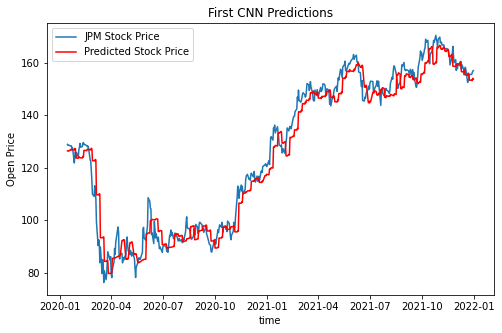

In [73]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_3.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_cnn3.pdf", bbox_inches='tight', format="pdf")

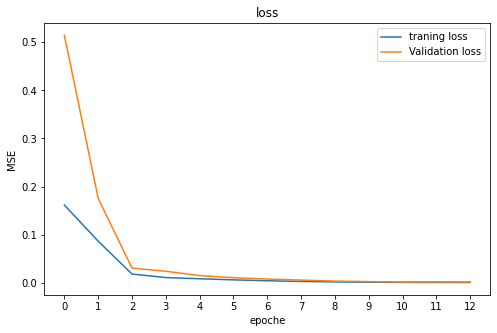

In [74]:
epoche = model_4_fit.history['val_loss']
fig = plt.figure(figsize=(8,5))
plt.plot(model_4_fit.history['loss'], label="traning loss")
plt.plot(model_4_fit.history['val_loss'], label = "Validation loss")
plt.xticks(range(0,len(epoche)))
plt.xlabel("epoche")
plt.ylabel("MSE")
plt.title("loss")
plt.legend()
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\loss_cnn3.pdf", bbox_inches='tight', format="pdf")

In [79]:
# aggiungo un livello convolutivo in più
model_5_CNN_4 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 3,activation='relu', kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.Conv1D(40, kernel_size = 2,activation='relu', kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(30, activation="relu", kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.Dense(5, activation = "relu", kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02))
    ]
)
model_5_CNN_4.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 3, 64)             256       
                                                                 
 conv1d_21 (Conv1D)          (None, 2, 40)             5160      
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 1, 40)            0         
 g1D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 40)                0         
                                                                 
 dense_36 (Dense)            (None, 30)                1230      
                                                                 
 dense_37 (Dense)            (None, 5)                 155       
                                                     

In [80]:
model_5_CNN_4.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_5_fit=model_5_CNN_4.fit(X_train,y_train,epochs=20,batch_size=4, callbacks=[earlyStop], validation_split=0.1)

Epoch 1/20
57/57 [==============================] - 1s 4ms/step - loss: 0.0546 - root_mean_squared_error: 0.2336 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0977
Epoch 2/20
57/57 [==============================] - 0s 2ms/step - loss: 0.0023 - root_mean_squared_error: 0.0478 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 3/20
57/57 [==============================] - 0s 2ms/step - loss: 6.3040e-04 - root_mean_squared_error: 0.0251 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0423
Epoch 4/20
57/57 [==============================] - 0s 3ms/step - loss: 7.6757e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 5/20
57/57 [==============================] - 0s 2ms/step - loss: 6.9948e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 6/20
57/57 [==============================] - 0s 2ms/step - loss: 9.7825e-04 - root_mean_squared_error: 0.0313 - val_loss: 0.0014 - 

Mean Squared Error:	 25.849865927895646
Root Mean Squared Error:	 5.084276342597405


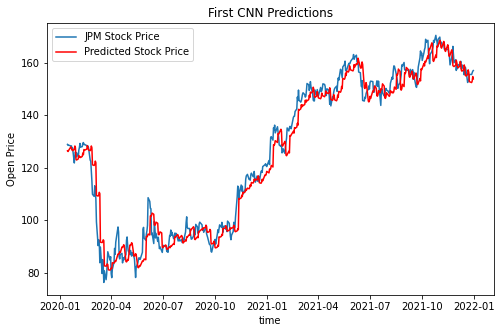

In [81]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_4.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'].values, predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_cnn4.pdf", bbox_inches='tight', format="pdf")

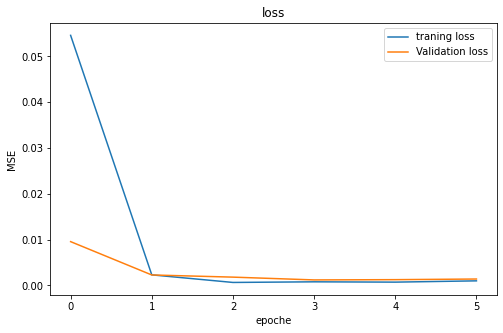

In [84]:
epoche = model_5_fit.history['val_loss']
fig = plt.figure(figsize=(8,5))
plt.plot(model_5_fit.history['loss'], label="traning loss")
plt.plot(model_5_fit.history['val_loss'], label = "Validation loss")
plt.xticks(range(0,len(epoche)))
plt.xlabel("epoche")
plt.ylabel("MSE")
plt.title("loss")
plt.legend()
plt.show()
#fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\loss_cnn4.pdf", bbox_inches='tight', format="pdf")

In [96]:
# USO COME FUNZIONE DI ATTIVAZIONE DEL LIVELLO DI OUTPUT LA FUNZIONE LINEARE
model_5_CNN_5 = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 2,activation='relu', kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu",kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02)),
     layers.Dense(5, activation = "linear",kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=0.02))
    ]
)
model_5_CNN_5.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 4, 64)             192       
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                            
                                                                 
 flatten_24 (Flatten)        (None, 128)               0         
                                                                 
 dense_48 (Dense)            (None, 32)                4128      
                                                                 
 dense_49 (Dense)            (None, 5)                 165       
                                                                 
Total params: 4,485
Trainable params: 4,485
Non-trainable params: 0
___________________________________________________

In [97]:
model_5_CNN_5.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_6_fit=model_5_CNN_5.fit(X_train,y_train,epochs=20,batch_size=4, validation_split=0.1, callbacks=[earlyStop])

Epoch 1/20
57/57 [==============================] - 0s 3ms/step - loss: 0.0654 - root_mean_squared_error: 0.2558 - val_loss: 0.0845 - val_root_mean_squared_error: 0.2907
Epoch 2/20
57/57 [==============================] - 0s 2ms/step - loss: 0.0063 - root_mean_squared_error: 0.0791 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0513
Epoch 3/20
57/57 [==============================] - 0s 2ms/step - loss: 7.8777e-04 - root_mean_squared_error: 0.0281 - val_loss: 9.9183e-04 - val_root_mean_squared_error: 0.0315
Epoch 4/20
57/57 [==============================] - 0s 2ms/step - loss: 6.1029e-04 - root_mean_squared_error: 0.0247 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 5/20
57/57 [==============================] - 0s 2ms/step - loss: 6.2200e-04 - root_mean_squared_error: 0.0249 - val_loss: 9.6700e-04 - val_root_mean_squared_error: 0.0311
Epoch 6/20
57/57 [==============================] - 0s 2ms/step - loss: 5.9812e-04 - root_mean_squared_error: 0.0245 - val_loss: 0

Mean Squared Error:	 24.75981911882185
Root Mean Squared Error:	 4.975923946245747


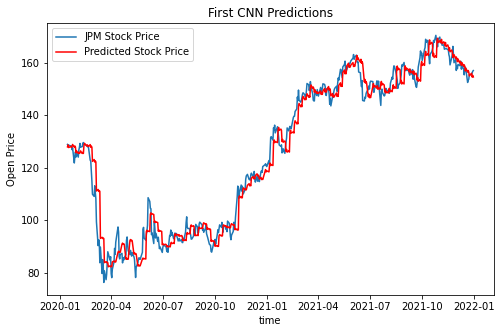

In [99]:
# MSE ed previsioni
predicted_stock_price = model_5_CNN_5.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show() 
fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\prev_cnn5.pdf", bbox_inches='tight', format="pdf")

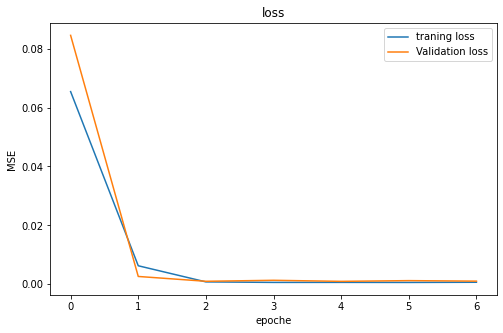

In [100]:
epoche = model_6_fit.history['val_loss']
fig = plt.figure(figsize=(8,5))
plt.plot(model_6_fit.history['loss'], label="traning loss")
plt.plot(model_6_fit.history['val_loss'], label = "Validation loss")
plt.xticks(range(0,len(epoche)))
plt.xlabel("epoche")
plt.ylabel("MSE")
plt.title("loss")
plt.legend()
plt.show()
fig.savefig("E:\Laurea Magistrale\Artificial intelligence and deep learning\Esame\grafici\loss_cnn5.pdf", bbox_inches='tight', format="pdf")

In [84]:
# WALK-FORWARD VALIDATION CON FINESTRA TEMPORALE DI 10 GIORNI
# training set
X_train = []
y_train = []
temp = 5
for i in range(temp, training_set_scaled.shape[0], temp):
  X_train.append(training_set_scaled[i-temp:i+temp, 0])
  y_train.append(training_set_scaled[i:i+temp, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(253, 10)
(253, 10, 1)
(253, 5)


In [85]:
# creazione del test set
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
print(dataset_total.shape)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - temp-temp:].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
inputs = mc.fit_transform(inputs)
print(inputs.shape)

X_test = []
for i in range(5, inputs.shape[0], 5):
  X_test.append(inputs[i-temp:i+temp, 0])
X_test = np.array(X_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(1765,)
(505,)
(505, 1)
(100, 10)
(100, 10, 1)


RETE LSTM

In [103]:
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu")(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 3, activation = "relu")(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
#decoder_lstm1 = keras.layers.LSTM(200, return_sequences=True, activation="relu")(encoder_outputs)
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm2 = keras.layers.LSTM(200, return_sequences=True, activation="relu")(repeat)
decoder = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm2)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu"))(decoder)

model_LSTM = keras.Model(encoder_inputs, output)
model_LSTM.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 conv1d_50 (Conv1D)          (None, 8, 64)             256       
                                                                 
 conv1d_51 (Conv1D)          (None, 6, 64)             12352     
                                                                 
 max_pooling1d_37 (MaxPoolin  (None, 3, 64)            0         
 g1D)                                                            
                                                                 
 flatten_37 (Flatten)        (None, 192)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 5, 192)           0         
 or)                                                       

In [104]:
model_LSTM.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_LSTM.fit(X_train, y_train, batch_size=16, epochs=20, validation_split=0.1, callbacks=[earlyStop])

Epoch 1/20
15/15 [==============================] - 3s 42ms/step - loss: 0.1000 - root_mean_squared_error: 0.3162 - val_loss: 0.0780 - val_root_mean_squared_error: 0.2792
Epoch 2/20
15/15 [==============================] - 0s 14ms/step - loss: 0.0234 - root_mean_squared_error: 0.1531 - val_loss: 0.0460 - val_root_mean_squared_error: 0.2145
Epoch 3/20
15/15 [==============================] - 0s 14ms/step - loss: 0.0123 - root_mean_squared_error: 0.1109 - val_loss: 0.0262 - val_root_mean_squared_error: 0.1620
Epoch 4/20
15/15 [==============================] - 0s 15ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873
Epoch 5/20
15/15 [==============================] - 0s 13ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0527
Epoch 6/20
15/15 [==============================] - 0s 14ms/step - loss: 7.6566e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0014 - val_ro

Mean Squared Error:	 43.43605277123152
Root Mean Squared Error:	 6.590603369285056


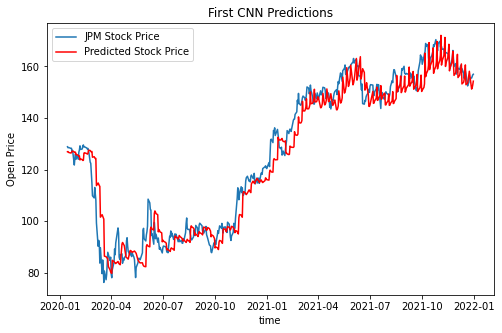

In [105]:
# MSE ed previsioni
predicted_stock_price = model_LSTM.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(predicted_stock_price.shape[0],5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [124]:
# cambio la funzione di attivazione del layer LSTM: utilizzo tanh
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu")(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 3, activation = "relu")(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True)(repeat)
decoder = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu"))(decoder)

model_LSTM_2 = keras.Model(encoder_inputs, output)
model_LSTM_2.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 10, 1)]           0         
                                                                 
 conv1d_64 (Conv1D)          (None, 8, 64)             256       
                                                                 
 conv1d_65 (Conv1D)          (None, 6, 64)             12352     
                                                                 
 max_pooling1d_44 (MaxPoolin  (None, 3, 64)            0         
 g1D)                                                            
                                                                 
 flatten_44 (Flatten)        (None, 192)               0         
                                                                 
 repeat_vector_9 (RepeatVect  (None, 5, 192)           0         
 or)                                                       

In [125]:
model_LSTM_2.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_LSTM_2.fit(X_train, y_train, batch_size=16, epochs=20)

Epoch 1/20
16/16 [==============================] - 5s 19ms/step - loss: 0.0632 - root_mean_squared_error: 0.2514
Epoch 2/20
16/16 [==============================] - 0s 12ms/step - loss: 0.0123 - root_mean_squared_error: 0.1107
Epoch 3/20
16/16 [==============================] - 0s 12ms/step - loss: 0.0034 - root_mean_squared_error: 0.0584
Epoch 4/20
16/16 [==============================] - 0s 12ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382
Epoch 5/20
16/16 [==============================] - 0s 12ms/step - loss: 6.3570e-04 - root_mean_squared_error: 0.0252
Epoch 6/20
16/16 [==============================] - 0s 11ms/step - loss: 3.7422e-04 - root_mean_squared_error: 0.0193
Epoch 7/20
16/16 [==============================] - 0s 12ms/step - loss: 3.1229e-04 - root_mean_squared_error: 0.0177
Epoch 8/20
16/16 [==============================] - 0s 12ms/step - loss: 3.8368e-04 - root_mean_squared_error: 0.0196
Epoch 9/20
16/16 [==============================] - 0s 12ms/step - loss:

Mean Squared Error:	 34.57348611764574
Root Mean Squared Error:	 5.879922288401926


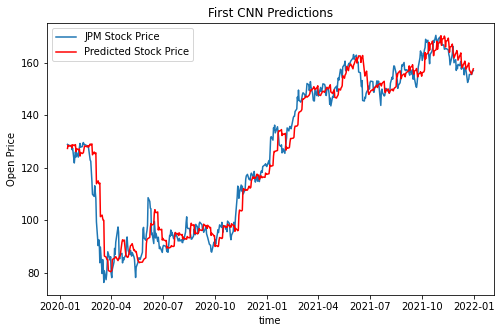

In [126]:
# MSE ed previsioni
predicted_stock_price = model_LSTM_2.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(predicted_stock_price.shape[0],5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [131]:
# stessa rete precedente con implementazione dell'early stopping
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu")(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 3, activation = "relu")(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True)(repeat)
decoder = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu"))(decoder)

model_LSTM_2 = keras.Model(encoder_inputs, output)
model_LSTM_2.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[keras.metrics.RootMeanSquaredError()])
model_LSTM_2.fit(X_train, y_train, batch_size=16, epochs=20, validation_split=0.1, callbacks=[earlyStop])

Epoch 1/20
15/15 [==============================] - 6s 123ms/step - loss: 0.0516 - root_mean_squared_error: 0.2271 - val_loss: 0.1056 - val_root_mean_squared_error: 0.3250
Epoch 2/20
15/15 [==============================] - 0s 15ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 0.0197 - val_root_mean_squared_error: 0.1404
Epoch 3/20
15/15 [==============================] - 0s 16ms/step - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0830
Epoch 4/20
15/15 [==============================] - 0s 16ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0499
Epoch 5/20
15/15 [==============================] - 0s 15ms/step - loss: 4.9925e-04 - root_mean_squared_error: 0.0223 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0335
Epoch 6/20
15/15 [==============================] - 0s 14ms/step - loss: 2.6863e-04 - root_mean_squared_error: 0.0164 - val_loss: 9.8341e-04

Mean Squared Error:	 37.5931303676078
Root Mean Squared Error:	 6.1313237043568165


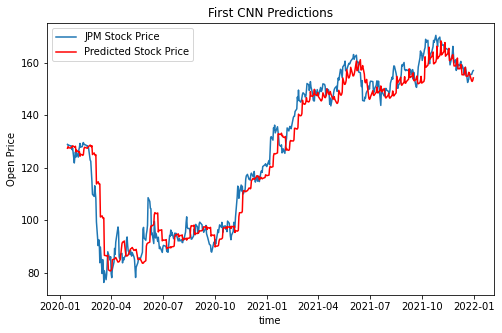

In [132]:
# MSE ed previsioni
predicted_stock_price = model_LSTM_2.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(predicted_stock_price.shape[0],5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [137]:
# porto il valore del learing rate a 0.02, utilizzando la rete "model_LSTM_2"
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu")(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 3, activation = "relu")(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True)(repeat)
decoder = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu"))(decoder)

model_LSTM_2 = keras.Model(encoder_inputs, output)
optimizer=keras.optimizers.Adam(learning_rate=0.02)
model_LSTM_2.compile(loss=keras.losses.mean_squared_error, optimizer=optimizer, metrics=[keras.metrics.RootMeanSquaredError()])
model_LSTM_2.fit(X_train, y_train, batch_size=16, epochs=20, validation_split=0.1, callbacks=[earlyStop])



Epoch 1/20
15/15 [==============================] - 5s 73ms/step - loss: 0.3305 - root_mean_squared_error: 0.5749 - val_loss: 0.4212 - val_root_mean_squared_error: 0.6490
Epoch 2/20
15/15 [==============================] - 0s 17ms/step - loss: 0.1141 - root_mean_squared_error: 0.3377 - val_loss: 0.4000 - val_root_mean_squared_error: 0.6325
Epoch 3/20
15/15 [==============================] - 0s 15ms/step - loss: 0.1112 - root_mean_squared_error: 0.3334 - val_loss: 0.3975 - val_root_mean_squared_error: 0.6305
Epoch 4/20
15/15 [==============================] - 0s 17ms/step - loss: 0.1097 - root_mean_squared_error: 0.3312 - val_loss: 0.3978 - val_root_mean_squared_error: 0.6307
Epoch 5/20
15/15 [==============================] - 0s 15ms/step - loss: 0.1097 - root_mean_squared_error: 0.3313 - val_loss: 0.3986 - val_root_mean_squared_error: 0.6313


Mean Squared Error:	 2052.0561460401027
Root Mean Squared Error:	 45.29962633444235


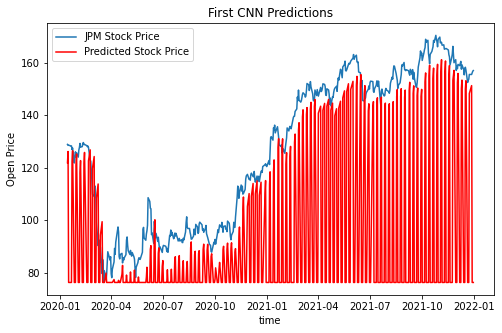

In [138]:
predicted_stock_price = model_LSTM_2.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(predicted_stock_price.shape[0],5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()
# aumentando il learning rate il modello ha un coportamento molto variabile sia sul training che sul test set.

In [141]:
# aggiungo un livello lstm e denso che lavorano in parallelo sul modulo di decoder
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu")(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 2, activation = "relu")(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True)(repeat)
decoder1 = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm)
decoder_lstm2 = keras.layers.LSTM(200, return_sequences=True)(repeat)
decoder2 =keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm2)
conc = keras.layers.concatenate([decoder1,decoder2])
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu"))(conc)

model_LSTM_3 = keras.Model(encoder_inputs, output)
model_LSTM_3.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_56 (InputLayer)          [(None, 10, 1)]      0           []                               
                                                                                                  
 conv1d_82 (Conv1D)             (None, 8, 64)        256         ['input_56[0][0]']               
                                                                                                  
 conv1d_83 (Conv1D)             (None, 7, 64)        8256        ['conv1d_82[0][0]']              
                                                                                                  
 max_pooling1d_53 (MaxPooling1D  (None, 3, 64)       0           ['conv1d_83[0][0]']              
 )                                                                                         

In [142]:
model_LSTM_3.compile(loss=keras.losses.mean_squared_error, optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])
model_LSTM_3.fit(X_train, y_train, batch_size=16, epochs=20, validation_split=0.1, callbacks=[earlyStop])

Epoch 1/20
15/15 [==============================] - 8s 135ms/step - loss: 0.0397 - root_mean_squared_error: 0.1992 - val_loss: 0.0531 - val_root_mean_squared_error: 0.2305
Epoch 2/20
15/15 [==============================] - 0s 26ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0944
Epoch 3/20
15/15 [==============================] - 0s 21ms/step - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0724
Epoch 4/20
15/15 [==============================] - 0s 20ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 5/20
15/15 [==============================] - 0s 18ms/step - loss: 6.5895e-04 - root_mean_squared_error: 0.0257 - val_loss: 6.2716e-04 - val_root_mean_squared_error: 0.0250
Epoch 6/20
15/15 [==============================] - 0s 20ms/step - loss: 3.4076e-04 - root_mean_squared_error: 0.0185 - val_loss: 7.5579

Mean Squared Error:	 44.97960437014145
Root Mean Squared Error:	 6.706683559714254


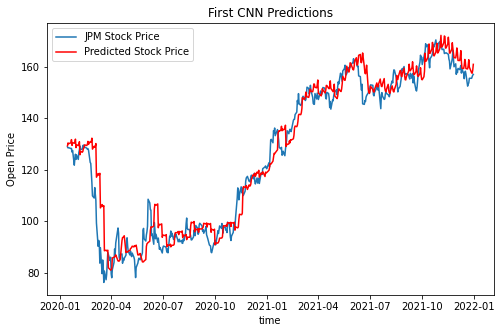

In [143]:
predicted_stock_price = model_LSTM_3.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(predicted_stock_price.shape[0],5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [152]:
# cambio la dimensione del minibatch sulla rete "model_LSTM_2"
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu")(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 3, activation = "relu")(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True)(repeat)
decoder = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "relu"))(decoder)

model_LSTM_2 = keras.Model(encoder_inputs, output)
model_LSTM_2.compile(loss=keras.losses.mean_squared_error, optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])
model_LSTM_2.fit(X_train, y_train, batch_size=4, epochs=20, validation_split=0.1, callbacks=[earlyStop])

Epoch 1/20
57/57 [==============================] - 6s 26ms/step - loss: 0.0172 - root_mean_squared_error: 0.1311 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0686
Epoch 2/20
57/57 [==============================] - 1s 12ms/step - loss: 7.6495e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 3/20
57/57 [==============================] - 1s 11ms/step - loss: 2.7847e-04 - root_mean_squared_error: 0.0167 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 4/20
57/57 [==============================] - 1s 11ms/step - loss: 4.0197e-04 - root_mean_squared_error: 0.0200 - val_loss: 8.6130e-04 - val_root_mean_squared_error: 0.0293
Epoch 5/20
57/57 [==============================] - 1s 11ms/step - loss: 3.1438e-04 - root_mean_squared_error: 0.0177 - val_loss: 5.6703e-04 - val_root_mean_squared_error: 0.0238
Epoch 6/20
57/57 [==============================] - 1s 11ms/step - loss: 3.0703e-04 - root_mean_squared_error: 0.0175 - v

Mean Squared Error:	 36.502297322961205
Root Mean Squared Error:	 6.041713111606774


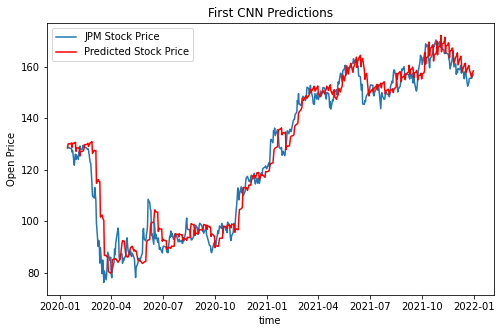

In [153]:
predicted_stock_price = model_LSTM_2.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(predicted_stock_price.shape[0],5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()

In [155]:
# cambio la funzione di attivazione del layer di output, utilizzando la funzione lineare, (modello "model_LSTM_2")
# cambio la dimensione del minibatch sulla rete "model_LSTM_2"
# encoder
encoder_inputs = keras.Input(shape=(10,1))
encoder_cnn = keras.layers.Conv1D(64,kernel_size = 3, activation = "relu")(encoder_inputs)
encoder_cnn = keras.layers.Conv1D(64, kernel_size = 3, activation = "relu")(encoder_cnn)
encoder_cnn = keras.layers.MaxPooling1D(pool_size = 2)(encoder_cnn)
encoder_cnn = keras.layers.Flatten()(encoder_cnn)
encoder_outputs = encoder_cnn

#decoder
repeat = keras.layers.RepeatVector(5)(encoder_outputs)
decoder_lstm = keras.layers.LSTM(200, return_sequences=True)(repeat)
decoder = keras.layers.TimeDistributed(keras.layers.Dense(100, activation ="relu"))(decoder_lstm)
output = keras.layers.TimeDistributed(keras.layers.Dense(1, activation = "linear"))(decoder)

model_LSTM_4 = keras.Model(encoder_inputs, output)
model_LSTM_4.compile(loss=keras.losses.mean_squared_error, optimizer='adam', metrics=[keras.metrics.RootMeanSquaredError()])
model_LSTM_4.fit(X_train, y_train, batch_size=4, epochs=20, validation_split=0.1, callbacks=[earlyStop])

Epoch 1/20
57/57 [==============================] - 5s 28ms/step - loss: 0.0209 - root_mean_squared_error: 0.1444 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0739
Epoch 2/20
57/57 [==============================] - 1s 11ms/step - loss: 7.1327e-04 - root_mean_squared_error: 0.0267 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 3/20
57/57 [==============================] - 1s 10ms/step - loss: 2.6645e-04 - root_mean_squared_error: 0.0163 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345
Epoch 4/20
57/57 [==============================] - 1s 10ms/step - loss: 3.3883e-04 - root_mean_squared_error: 0.0184 - val_loss: 7.9913e-04 - val_root_mean_squared_error: 0.0283
Epoch 5/20
57/57 [==============================] - 1s 11ms/step - loss: 2.5831e-04 - root_mean_squared_error: 0.0161 - val_loss: 6.3000e-04 - val_root_mean_squared_error: 0.0251
Epoch 6/20
57/57 [==============================] - 1s 11ms/step - loss: 8.9379e-04 - root_mean_squared_error: 0.0299 - v

Mean Squared Error:	 36.502297322961205
Root Mean Squared Error:	 6.041713111606774


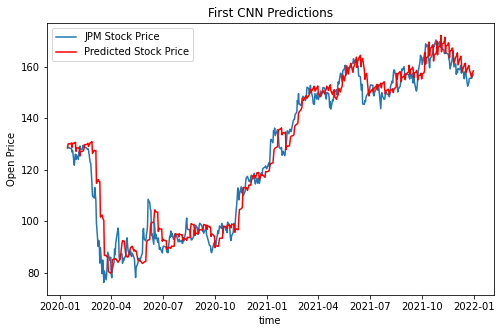

In [156]:
predicted_stock_price = model_LSTM_2.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(predicted_stock_price.shape[0],5)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price.reshape(-1,1)
predicted_stock_price = pd.DataFrame(predicted_stock_price[0:495])
predicted_stock_price = predicted_stock_price.set_index(dataset_test.index)
print("Mean Squared Error:\t", mean_squared_error(dataset_test['Open'], predicted_stock_price))
print("Root Mean Squared Error:\t", np.sqrt(mean_squared_error(dataset_test['Open'].values, predicted_stock_price)))
fig = plt.figure(figsize=(8,5))
plt.plot(dataset_test['Open'], label ="JPM Stock Price")
plt.plot(predicted_stock_price, label = "Predicted Stock Price", color = "red")
plt.ylabel("Open Price")
plt.xlabel("time")
plt.title("First CNN Predictions")
plt.legend()
plt.show()